In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter


In [2]:
PROJECT_ROOT = Path.cwd().parents[0]  # if notebook is in /notebooks
DATA_DIR = PROJECT_ROOT / "data" / "processed"

train_path = DATA_DIR / "train_edges.csv"
test_path  = DATA_DIR / "test_edges.csv"
core_path  = DATA_DIR / "core_nodes.txt"

train_edges = pd.read_csv(train_path)
test_edges  = pd.read_csv(test_path)
core_nodes  = set(map(int, core_path.read_text().splitlines()))

train_edges.head(), test_edges.head(), len(core_nodes)


(       u      v
 0  28461  65123
 1  16044  18264
 2  22482  32581
 3  19224  53942
 4  10108  64391,
        u      v
 0  34503  54567
 1  17667  45521
 2  29515  57648
 3  31023  47283
 4   3266  59908,
 3942)

In [3]:
G = nx.Graph()
G.add_edges_from(train_edges[["u", "v"]].itertuples(index=False, name=None))

n = G.number_of_nodes()
m = G.number_of_edges()
avg_k = 2*m / n

print(f"Train graph: n={n:,}, m={m:,}, <k>={avg_k:.3f}")


Train graph: n=9,373, m=20,778, <k>=4.434


In [4]:
components = sorted(nx.connected_components(G), key=len, reverse=True)
gcc = components[0]
G_gcc = G.subgraph(gcc).copy()

print(f"#components = {len(components)}")
print(f"GCC size = {len(gcc):,} nodes ({len(gcc)/n:.2%} of nodes)")
print(f"GCC edges = {G_gcc.number_of_edges():,}")


#components = 424
GCC size = 8,119 nodes (86.62% of nodes)
GCC edges = 19,728


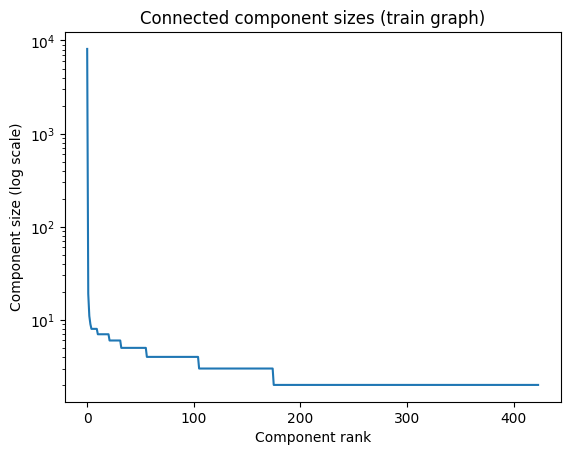

In [5]:
comp_sizes = [len(c) for c in components]

plt.figure()
plt.plot(sorted(comp_sizes, reverse=True))
plt.yscale("log")
plt.xlabel("Component rank")
plt.ylabel("Component size (log scale)")
plt.title("Connected component sizes (train graph)")
plt.show()


In [6]:
degrees = [d for _, d in G_gcc.degree()]
deg_counts = Counter(degrees)

ks = np.array(sorted(deg_counts.keys()))
pk = np.array([deg_counts[k] for k in ks]) / len(degrees)

print(f"Min degree={min(degrees)}, Max degree={max(degrees)}")


Min degree=1, Max degree=51


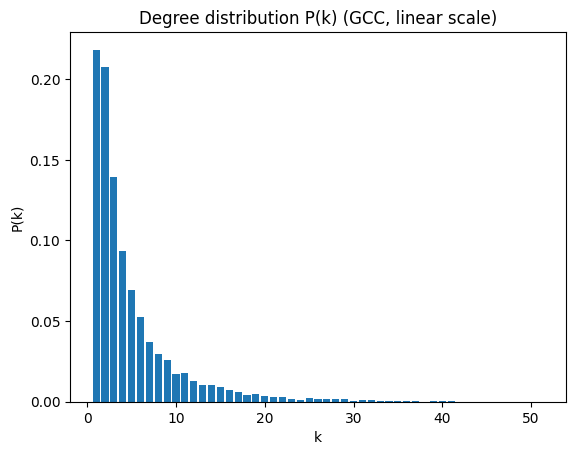

In [7]:
plt.figure()
plt.bar(ks, pk)
plt.xlabel("k")
plt.ylabel("P(k)")
plt.title("Degree distribution P(k) (GCC, linear scale)")
plt.show()


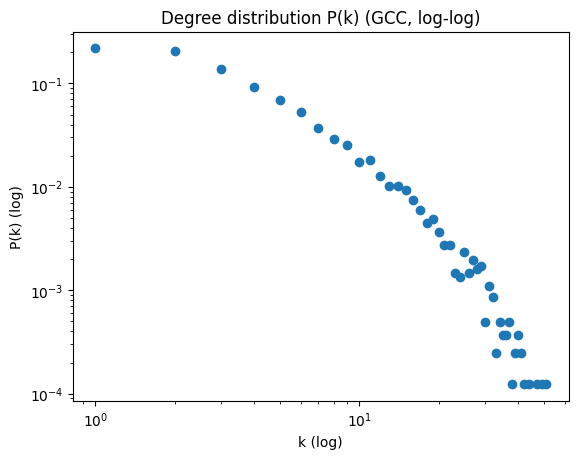

In [8]:
plt.figure()
plt.scatter(ks, pk)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k (log)")
plt.ylabel("P(k) (log)")
plt.title("Degree distribution P(k) (GCC, log-log)")
plt.show()


In [9]:
C_avg = nx.average_clustering(G_gcc)
print(f"Average clustering coefficient (GCC): C={C_avg:.4f}")


Average clustering coefficient (GCC): C=0.3403


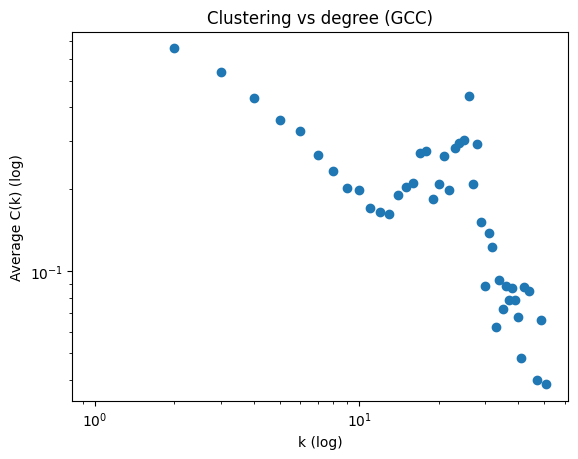

In [10]:
clust = nx.clustering(G_gcc)
deg = dict(G_gcc.degree())

ck_map = {}
for node, c in clust.items():
    k = deg[node]
    ck_map.setdefault(k, []).append(c)

ks_ck = np.array(sorted(ck_map.keys()))
ck = np.array([np.mean(ck_map[k]) for k in ks_ck])

plt.figure()
plt.scatter(ks_ck, ck)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k (log)")
plt.ylabel("Average C(k) (log)")
plt.title("Clustering vs degree (GCC)")
plt.show()


In [11]:
import random

def approx_distances(G, num_sources=50, seed=42):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    sources = rng.sample(nodes, k=min(num_sources, len(nodes)))

    dists = []
    ecc = []  # eccentricity of sources (approx)
    for s in sources:
        sp = nx.single_source_shortest_path_length(G, s)
        vals = list(sp.values())
        dists.extend(vals)
        ecc.append(max(vals))
    return np.mean(dists), np.percentile(dists, 90), max(ecc)

avg_dist, eff_diam_90, approx_diam = approx_distances(G_gcc, num_sources=60)
print(f"Approx avg shortest-path length (GCC): {avg_dist:.3f}")
print(f"Approx effective diameter (90th percentile): {eff_diam_90:.1f}")
print(f"Approx diameter (max over sampled sources): {approx_diam}")


Approx avg shortest-path length (GCC): 6.483
Approx effective diameter (90th percentile): 9.0
Approx diameter (max over sampled sources): 17


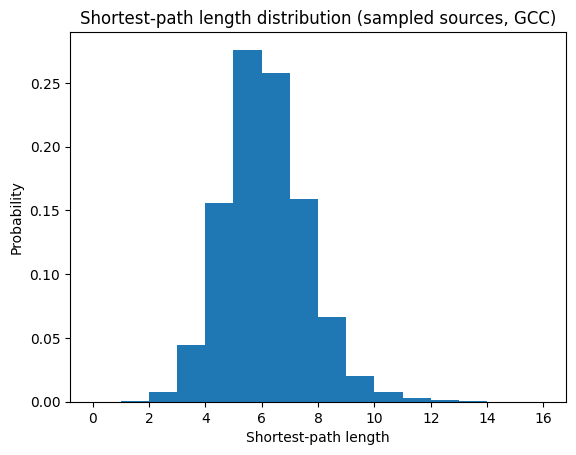

In [12]:
def dist_hist(G, num_sources=5, seed=42):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    sources = rng.sample(nodes, k=min(num_sources, len(nodes)))

    all_vals = []
    for s in sources:
        sp = nx.single_source_shortest_path_length(G, s)
        all_vals.extend(sp.values())
    return all_vals

vals = dist_hist(G_gcc, num_sources=8)
plt.figure()
plt.hist(vals, bins=range(0, max(vals)+2), density=True)
plt.xlabel("Shortest-path length")
plt.ylabel("Probability")
plt.title("Shortest-path length distribution (sampled sources, GCC)")
plt.show()


In [13]:
n0 = G_gcc.number_of_nodes()
m0 = G_gcc.number_of_edges()
avg_k0 = 2*m0 / n0
p = avg_k0 / (n0 - 1)

print(f"GCC: n={n0:,}, m={m0:,}, <k>={avg_k0:.3f}")
print(f"ER parameter p = {p:.6e}")

G_er = nx.gnp_random_graph(n0, p, seed=42)


GCC: n=8,119, m=19,728, <k>=4.860
ER parameter p = 5.986341e-04


In [14]:
m_ba = max(1, int(round(avg_k0 / 2)))
print(f"BA parameter m = {m_ba}")

G_ba = nx.barabasi_albert_graph(n0, m_ba, seed=42)


BA parameter m = 2


In [15]:
def graph_metrics(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    avg_k = 2*m / n
    C = nx.average_clustering(G)
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    gcc_frac = len(comps[0]) / n
    return {"n": n, "m": m, "<k>": avg_k, "C": C, "GCC_frac": gcc_frac}

metrics_real = graph_metrics(G_gcc)
metrics_er   = graph_metrics(G_er)
metrics_ba   = graph_metrics(G_ba)

pd.DataFrame([metrics_real, metrics_er, metrics_ba], index=["Real (GCC)", "ER", "BA"])


,n,m,<k>,C,GCC_frac
Real (GCC),8119,19728,4.859712,0.340294,1.000000
ER,8119,19564,4.819313,0.000648,0.993595
BA,8119,16234,3.999015,0.005043,1.000000


In [16]:
deg_seq = [d for _, d in G_gcc.degree()]
G_cfg = nx.configuration_model(deg_seq, seed=42)
G_cfg = nx.Graph(G_cfg)  # remove parallel edges
G_cfg.remove_edges_from(nx.selfloop_edges(G_cfg))

metrics_cfg = graph_metrics(G_cfg)

pd.DataFrame([metrics_real, metrics_er, metrics_ba, metrics_cfg],
             index=["Real (GCC)", "ER", "BA", "ConfigModel"])


,n,m,<k>,C,GCC_frac
Real (GCC),8119,19728,4.859712,0.340294,1.000000
ER,8119,19564,4.819313,0.000648,0.993595
BA,8119,16234,3.999015,0.005043,1.000000
ConfigModel,8119,19704,4.853800,0.001216,0.988422


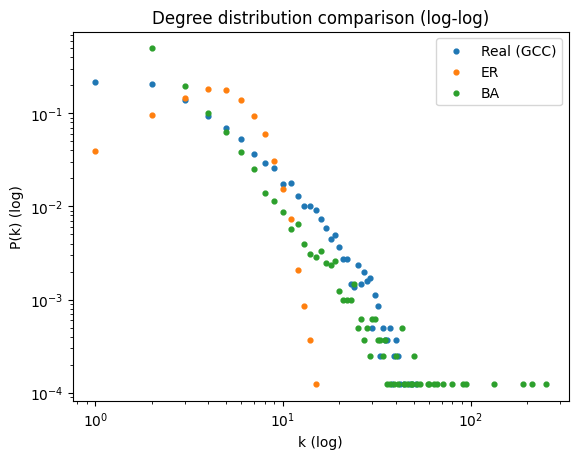

In [17]:
def degree_pk(G):
    degs = [d for _, d in G.degree()]
    counts = Counter(degs)
    ks = np.array(sorted(counts.keys()))
    pk = np.array([counts[k] for k in ks]) / len(degs)
    return ks, pk

ks_r, pk_r = degree_pk(G_gcc)
ks_e, pk_e = degree_pk(G_er)
ks_b, pk_b = degree_pk(G_ba)

plt.figure()
plt.scatter(ks_r, pk_r, label="Real (GCC)", s=12)
plt.scatter(ks_e, pk_e, label="ER", s=12)
plt.scatter(ks_b, pk_b, label="BA", s=12)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k (log)")
plt.ylabel("P(k) (log)")
plt.title("Degree distribution comparison (log-log)")
plt.legend()
plt.show()


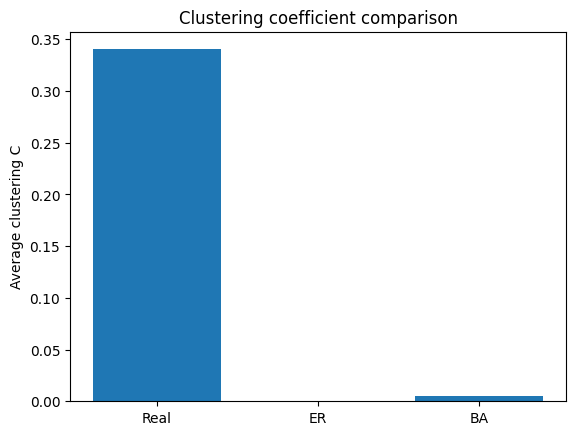

In [18]:
plt.figure()
plt.bar(["Real", "ER", "BA"], [metrics_real["C"], metrics_er["C"], metrics_ba["C"]])
plt.ylabel("Average clustering C")
plt.title("Clustering coefficient comparison")
plt.show()


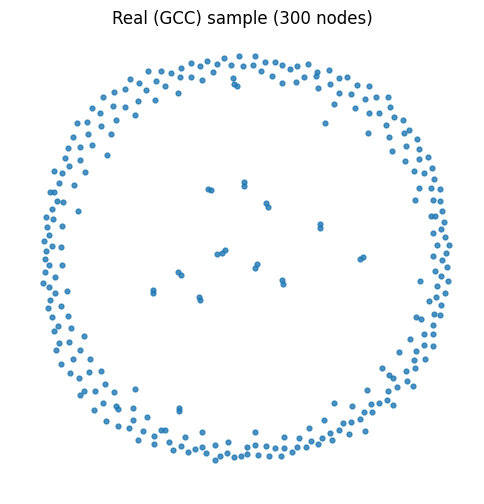

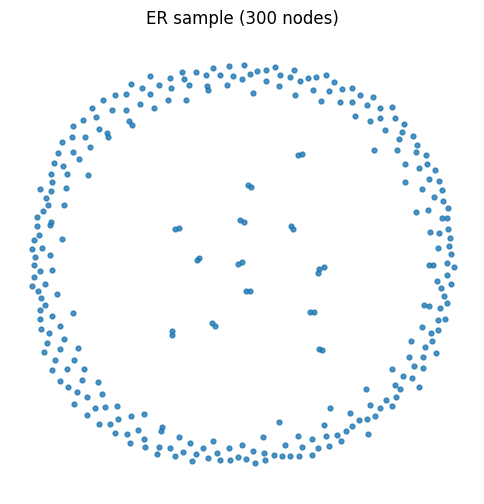

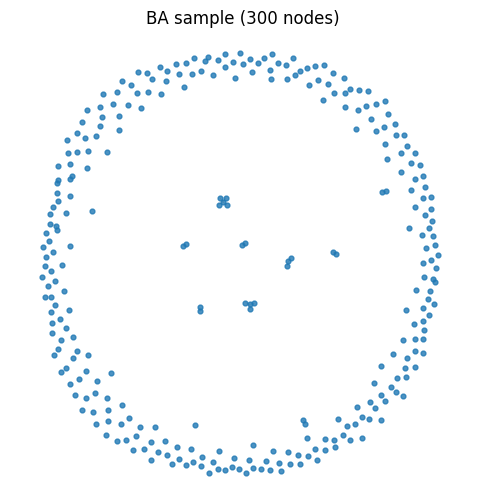

In [19]:
import random

def sample_subgraph(G, n_nodes=300, seed=42):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    sample = rng.sample(nodes, k=min(n_nodes, len(nodes)))
    return G.subgraph(sample).copy()

Gs_real = sample_subgraph(G_gcc, 300)
Gs_er   = sample_subgraph(G_er, 300)
Gs_ba   = sample_subgraph(G_ba, 300)

def draw_graph(G, title):
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=12, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.6)
    plt.title(title)
    plt.axis("off")
    plt.show()

draw_graph(Gs_real, "Real (GCC) sample (300 nodes)")
draw_graph(Gs_er,   "ER sample (300 nodes)")
draw_graph(Gs_ba,   "BA sample (300 nodes)")
